# Tennis Players: Elo vs Rank
Authors: Alan Zhang, Yovindu Don, Minghao Wang, Hefei Peng, Yuhan Liu
### Introduction
In the ATP (Association of Tennis Professionals), players are given points after each tournament, depending on their placement. However, the points are not dependent on the players one matched with. As a result, two players may have the same points even if they faced different levels of competition.On the contrary, the Elo system does take into account the player’s opponent. A player who defeats another player of a higher elo would receive more Elo points themselves than defeating a player of a lower caliber and has no maximum value unlike rank.

The Elo system makes it easier to analyze performance but is often difficult to calculate whereas ATP rankings are easily available. Thus, the aim for our analysis is to be able to predict the Elo of a player based on the player’s ranking, as to make truer comparisons between players more accessible. We will perform exploratory data analysis and visualizing using the dataset “Player Stats for Top 500 Players” retrieved online from https://www.ultimatetennisstatistics.com/.



In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(testthat)
library(digest)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
tennis_players <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")
colnames(tennis_players) <- c('','Age','Country','Plays','Wikipedia','Current_Rank','Best_Rank','Name','Backhand','Prize_Money','Height','Favorite_Surface','Turned_Pro','Seasons','Active','Current_Elo_Rank','Best_Elo_Rank','Peak_Elo_Rating','Last_Appearance','Titles','GOAT_Rank','Best_Season','Retired','Masters','Birthplace','Residence','Weight','Coach','Facebook','Twitter','Nicknames','Grand_Slams','Davis_Cups','Web_Site','Team_Cups','Olympics','Weeks_at_No.1','Tour_Finals')
tennis_players

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



,Age,Country,Plays,Wikipedia,Current_Rank,Best_Rank,Name,Backhand,Prize_Money,⋯,Facebook,Twitter,Nicknames,Grand_Slams,Davis_Cups,Web_Site,Team_Cups,Olympics,Weeks_at_No.1,Tour_Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Data Analysis
We will take rank and current elo columns for our data analysis. Current elo is the response variable while current rank is the explanatory variable. Empty rows wil be filtered to make data tidy and it will then be split into a training set (75 percent) and a testing set (25 percent). On top of that, we will standardize our dataset before taking further actions which include training our classifiers. In order to find the best K, we will be using the optimal K value within our nearest_neighbor function and K-NN regression will be used instead of classification as they are numerical values. We will be looking for the lowest RMSPE value (closest to 0) to help determine the best k value.Finally, predict and visualize the result using a scatter plot.


In [21]:
elo_rank_performance <- tennis_players %>%
    select(Current_Elo_Rank, Current_Rank) %>%
    filter(!is.na(Current_Rank)) %>%
    filter(!is.na(Current_Elo_Rank)) %>%
    separate(col = Current_Elo_Rank, into = c("Elo_Rank", "Elo"), sep = " ") %>%
    separate(col = Current_Rank, into = c("Rank", "Rank_Date"), sep = " ") %>%
    select(Elo, Rank)

elo_rank_performance$Elo <- substr(elo_rank_performance$Elo, 2, 5)

elo_rank_performance <- elo_rank_performance %>%
    transform(Elo = as.numeric(Elo)) %>%
    transform(Rank = as.numeric(Rank))

elo_rank_performance

Elo,Rank
<dbl>,<dbl>
1764,178
1826,183
1983,31
⋮,⋮
1764,292
1679,324
2188,5


In [27]:
set.seed(184)
elo_rank_split <- initial_split(elo_rank_performance, prop = 0.75, strata = Elo)
elo_rank_training <- training(elo_rank_split)
elo_rank_testing <- testing(elo_rank_split)

In [39]:
glimpse(elo_rank_training)
elo_rank_training

Rows: 140
Columns: 2
$ Elo  <dbl> 1764, 1983, 1602, 1926, 2204, 2211, 1919, 1993, 1705, 2004, 1773…
$ Rank <dbl> 178, 31, 417, 22, 4, 121, 34, 45, 123, 12, 84, 43, 161, 304, 41,…


,Elo,Rank
,<dbl>,<dbl>
1,1764,178
3,1983,31
4,1602,417
⋮,⋮,⋮
180,1952,71
182,1764,292
183,1679,324


After obtaining what we wanted, we will standardize our training data before taking any futher actions.

In [40]:
elo_rank_recipe <- recipe(Elo ~ Rank, data = elo_rank_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
elo_rank_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [41]:
elo_rank_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

elo_rank_vfold <- vfold_cv(elo_rank_training, v = 5, strata = Elo)

In [16], we created a recipe for preprocessing our data as well as standardized our training data. Here we used tune() and cross-validation to help choose the optimal K. We created a 5-fold cross validation object.

In [42]:
gridvals <- tibble(neighbors = seq(1,20))

elo_rank_results <- workflow() %>%
    add_recipe(elo_rank_recipe) %>%
    add_model(elo_rank_knn_spec) %>%
    tune_grid(elo_rank_vfold, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric == "rmse") %>%
    filter(mean == min(mean))


elo_rank_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,rmse,standard,85.68992,5,9.532755,Model08


We now know that our best optimal K = 5. 
Hence, we will be using K = 5.

In [ ]:
elo_rank_5_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("regression")

elo_rank_fit <- workflow() %>%
    add_recipe(elo_rank_recipe) %>%
    add_model(elo_rank_5_spec) %>%
    fit(data = elo_rank_training)

elo_rank_sum <- elo_rank_fit %>%
    predict(elo_rank_testing) %>%
    bind_cols(elo_rank_testing) %>%
    metrics(truth = Elo, estimate = .pred) %>%
    filter(.metric == "rmse")

elo_rank_sum 

By applying K = 5, we have our .estimate = 85.74153.
This is saying that we expect the error in our prediction to be roughly 85.74153.

### Expected Outcomes and Significance
Our prediction is that there is generally a positive association between an athlete’s rank and elo rating. This could be due to the simple fact that ranks reflect the actual abilities of a player during competitions. The higher ranks you get, the better you play in competitions, and the higher the capacities you have. The visualization suggests that each player’s rank increases along with their elos. Therefore, when predicting the skill levels of players, players are expected to have the higher ranks. 

The significance of our finding is that, our regression model helps interested groups to estimate the elo of a player using rank as a predictor. Clubs could sign contracts with players with higher Elo because they generally have higher skill levels. Accordingly, as winners gain more popularity among audiences, companies could refer to rank as a predictor of players’ capacities and reach out for more business cooperation with the ones with higher ranks. And for tennis bets, we can advise our clients to bid on players who have higher ranks in previous matches. 


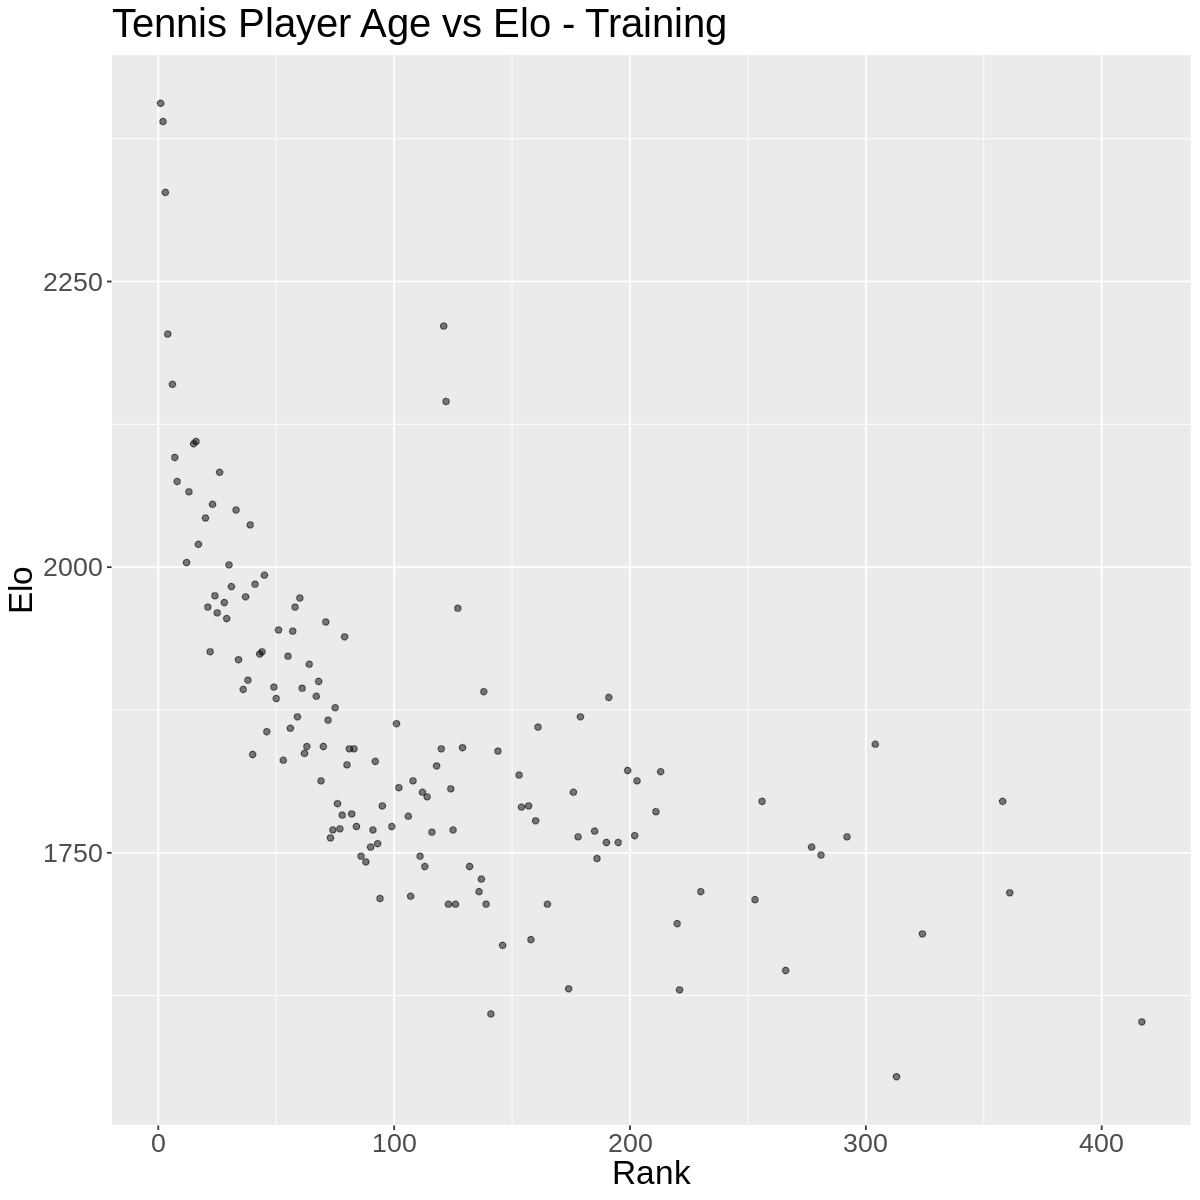

In [7]:
options(repr.plot.width = 10, repr.plot.height = 10)
elo_rank_training_plot <- ggplot(elo_rank_training, aes(x = Rank, y = Elo)) +
    geom_point(alpha = 0.5) +
    labs(x = "Rank", y = "Elo") +
    ggtitle("Tennis Player Age vs Elo - Training") +
    theme(text = element_text(size = 20))
elo_rank_training_plot